In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from ecgdetectors import Detectors

In [2]:
def collect_and_label(dataset):  # dataset = 'ptbxl_database.csv', function returns dataframe 'df'
    
    # collect only the MI classes and the NORM classes from the dataset.
    df = pd.read_csv(dataset)
    alpha = df['scp_codes'].str.split("'").str[1].str[-2:]=='MI'  # collect all the MI classes.
    beta = df['scp_codes'].str.split("'").str[1]=='NORM'       # collect all the Normal classes.
    df = df[alpha|beta]
    df['label'] = df['scp_codes'].str.split("'").str[1]      # create a new column 'label' which would contain categorical labels given to the classes.
    
    # Taking only 1000 records from each of the classes.
    
    # The classes with label == 'NORM', 'IMI', and 'ASMI' have more than 1000 instances. So, we need to downsample these classes.
    # Thus, the number of instances of each of these classes will become 1000 (and they will be chosen randomely).
    
    inst_c1 = df[df['label'] == 'NORM']
    inst_c1 = inst_c1.sample(n = 1000, random_state = 1)
    
    inst_c2 = df[df['label'] == 'IMI']
    inst_c2 = inst_c2.sample(n = 1000, random_state = 1)
    
    inst_c3 = df[df['label'] == 'ASMI']
    inst_c3 = inst_c3.sample(n = 1000, random_state = 1)
    
    k0 = (df['label'] == 'LMI')
    k1 = (df['label'] == 'AMI')
    k2 = (df['label'] == 'ILMI')
    k3 = (df['label'] == 'ALMI')
    k4 = (df['label'] == 'IPMI')
    k5 = (df['label'] == 'IPLMI')
    k6 = (df['label'] == 'PMI')
    
    inst_m = df[k0|k1|k2|k3|k4|k5|k6]
    
    df_new = pd.concat([inst_c1, inst_c2, inst_c3, inst_m], ignore_index = True)
    df_new = df_new.sample(frac = 1, random_state=42)
    
    return  df_new

In [3]:
collect_and_label('ptbxl_database.csv').head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,label
3188,5160,17263.0,37.0,0,NaN,NaN,0.0,0.0,CS100 3,1990-10-13 11:10:18,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/05000/05160_lr,records500/05000/05160_hr,LMI
3570,13150,21435.0,61.0,0,NaN,NaN,0.0,0.0,CS100 3,1994-10-09 10:44:43,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,2,records100/13000/13150_lr,records500/13000/13150_hr,ILMI
538,12752,14049.0,56.0,0,NaN,NaN,0.0,0.0,CS100 3,1994-08-10 11:51:22,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/12000/12752_lr,records500/12000/12752_hr,NORM
438,10545,906.0,57.0,1,183.0,86.0,4.0,1.0,AT-6 C 5.8,1993-07-16 12:29:36,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/10000/10545_lr,records500/10000/10545_hr,NORM
1545,19796,20390.0,75.0,0,NaN,NaN,1.0,2.0,CS-12,1998-10-21 10:48:12,...,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/19000/19796_lr,records500/19000/19796_hr,IMI


In [4]:
Counter(collect_and_label('ptbxl_database.csv')['label'])
#This shows all the classes (with their amount) to classify (So, 10 in our case).

Counter({'LMI': 132,
         'ILMI': 393,
         'NORM': 1000,
         'IMI': 1000,
         'ASMI': 1000,
         'AMI': 290,
         'IPLMI': 50,
         'ALMI': 164,
         'IPMI': 30,
         'PMI': 14})

<BarContainer object of 10 artists>

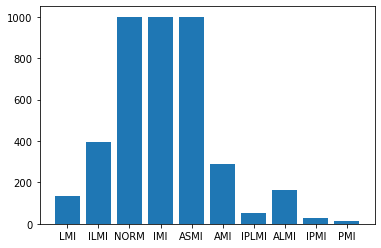

In [5]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH OF THE CLASSES PRESENT IN THE DATASET
my_dict = Counter(collect_and_label('ptbxl_database.csv')['label'])
keys = my_dict.keys()
values = my_dict.values()

plt.bar(keys, values)

In [6]:
def div_and_label(dataframe):   # dataframe = df_new, function returns X and y (labelled).
    
    # does the one-hot encoding of the labels and assigns them numbers between 0 to 9.
    
    X = dataframe[['ecg_id', 'filename_hr']]   #using the higher sampling frequency 
    X = X.to_numpy()
    y = dataframe['label']
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    
    return (X, encoded_y)

In [7]:
def balance_dat(X_in, y_in):    # X_in = X, y_in = encoded_y
    
    # balances the dataset to make each class have 1000 instances.
    
    smote_nc = SMOTENC(categorical_features=[1], random_state = 0)
    X_res, y_res = smote_nc.fit_resample(X_in, y_in)
    X_del = np.delete(X_res, 0, 1)
    
    return (X_del, y_res)

In [8]:
# collecting the values of input and target (obtained so far) in these variables as shown below, for further use.

alpha = collect_and_label('ptbxl_database.csv')   # the database file is imported to the jupyter notebook itself.
beta0, beta1 = div_and_label(alpha)
gamma0, gamma1 = balance_dat(beta0, beta1)

print(gamma0.shape)
print(gamma1.shape)

(10000, 1)
(10000,)


<BarContainer object of 10 artists>

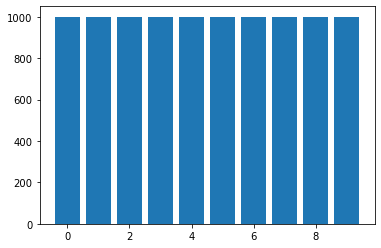

In [9]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH OF THE CLASSES AFTER THE AUGMENTATION AND BALANCING(OVER SAMPLING)

my_dict1 = Counter(gamma1)
keys1 = my_dict1.keys()
values1 = my_dict1.values()

plt.bar(keys1, values1)

In [10]:
def records_tt_split(Xin, yin):   # Xin = gamma0, yin = gamma1
    
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)    # 75%-25% split.
    
    skf.get_n_splits(Xin, yin)
    
    for train_index, test_index in skf.split(Xin, yin):
        X_train, X_test = Xin[train_index], Xin[test_index]
        y_train, y_test = yin[train_index], yin[test_index]
        
    return (X_train, X_test, y_train, y_test)

In [11]:
from scipy import signal
import matplotlib.pyplot as plt

In [12]:
# intialize global lists
final_list_X = []  # would contain lists of all 36 features extracted from the ECG beats
final_list_y = []  # would contain corresponding labels to the beats (0-9)

def load_raw_data(feat_inp, targ_inp):
    # feat_inp = gamma0, targ_inp = gamma1
    
    path = r'C:\Users\harsh raj\OneDrive\Desktop\ptb-xl-dataset-1.0.1'
    temp = feat_inp
    new_arr = np.reshape(temp, temp.shape[0])    # reshaping gamma0 (X_del) to an 1D array to make 'in' command work well.
    
    record_no = 0
    
    for f in new_arr:
        signal, meta_val = wfdb.rdsamp(path + '/' + f)   # signal.shape = (5000, 12)
        value = signal.T
        temp_list = []
        flag1 = -1
        
        for ind in range(12):
            val_ind = value[ind]
            tmpp = val_ind.shape[0]
            val_ind = val_ind.reshape(1, tmpp)
            val_filtered = filter_data(val_ind)
            val_filtered = val_filtered.reshape(val_filtered.shape[1], )  # converting (1, 5000) to (5000, ) i.e., 1-D array
            a_var = return_peaks(val_filtered)
            
            if(a_var == 'INCOMPLETE'):
                temp_list = []
                flag1 = 1
                break
            
            temp_list.append(a_var)
        
        
        if(flag1==-1):
            final_data_return(temp_list, targ_inp[record_no])
        
        record_no = record_no + 1


In [13]:
def filter_data(val):
    
    ecg = val 
    Fs = 500  # sampling frequency of the ECG signal.
    N = ecg.shape[1]
    t = ((np.linspace(0, N-1, N))/(Fs))
    cover = t.shape[0]
    t = t.reshape(1, cover)   # t must be of the same shape as xn.
    n=2    # order of filter.

    Fcutoff_low = 0.5 
    Wn_low = ((2*Fcutoff_low)/(Fs))
    b_low, a_low = signal.butter(n, Wn_low, 'low')
    xn_filtered_LF = signal.filtfilt(b_low, a_low, ecg)

    Fcutoff_high = 40 
    Wn_high = ((2*Fcutoff_high)/(Fs))
    b_high, a_high = signal.butter(n, Wn_high, 'high')
    xn_filtered_HF = signal.filtfilt(b_high, a_high, ecg)

    xn = (ecg-xn_filtered_HF-xn_filtered_LF)
    
    return xn

In [14]:
import neurokit2 as nk
import biosppy

In [15]:
def return_peaks(ecg_test):
    
    ''' clean the signal further with the neurokit '''

    cleaned = nk.ecg_clean(ecg_test, sampling_rate = 500)  


    ''' Detect the R-peaks for that lead '''

    rdet, = biosppy.ecg.hamilton_segmenter(signal = cleaned, sampling_rate = 500)   
    rdet, = biosppy.ecg.correct_rpeaks(signal = cleaned, rpeaks = rdet, sampling_rate = 500, tol = 0.05)
    
    if(rdet.size<=4):        # when just 4 or less rpeaks are found, there's no point of considering that whole record at all.
        return 'INCOMPLETE'
    
    rdet = np.delete(rdet, -1)       # remove the last R-peak to avoid the invalid detection for S and T peaks.
    rdet = np.delete(rdet, 0)        # remove the first R-peak to avoid the invalid detection for P and Q peaks.
    rpeaks = {'ECG_R_Peaks': rdet}    # created this dictionary to use it for the future use.

    ''' remove the baseline wander from the ECG lead '''

    cleaned_base = nk.signal_detrend(cleaned, order=0)

    ''' The features to be extracted are Q-wave amplitude, T-wave amplitude, and ST deviation.
                   (a) ST-deviation = (value of cleaned_base at QRS onset - value of cleaned_base at QRS offset).
                   (b) T amplitude = value of cleaned_base at the position of T peak.
                   (c) Q amplitude = value of cleaned_base at the position of Q peak. '''


    ''' ECG delineation using 'dwt' method for (i) T-Peak detection, (ii) QRS wave onsets and offsets: '''

    signals, waves = nk.ecg_delineate(cleaned_base, rpeaks, sampling_rate = 500, method = "dwt") 


    ''' ECG delineation using 'peak' method for Q-Peak detection. '''

    ''' for the peak detection using 'peak' method, we must have atleast 4 R-Peaks otherwise it shows an
     error due to incompatibility and then we won't be able to extract the time domain features. In that case,
     either we remove the complete ECG record or we keep on appending the array for the rpeaks (rpeaks['ECG_R_Peaks']) with the 
     last rpeak position until it's size becomes atleast 4.'''

    rpeakss = rpeaks.copy()  #just store the rpeaks in some other variable. .copy() is used to prevent the similar changes in rpeaks
    temppo = 4-len(rpeakss['ECG_R_Peaks'])

    if temppo>0:

        for i in range(temppo):
            rpeakss['ECG_R_Peaks'] = np.append(rpeakss['ECG_R_Peaks'], rpeakss['ECG_R_Peaks'][-1] + 1)


    signals1, waves1 = nk.ecg_delineate(cleaned_base, rpeakss, sampling_rate = 500, method = "peak")

    # To get the original Q peaks' positions, we remove the irrelevant ones.
    if temppo>0:
        for j in range(temppo):
            waves1['ECG_Q_Peaks'] = waves1['ECG_Q_Peaks'][:-1] #remove the last element by slicing.(waves1['ECG_Q_Peaks'] is a list)
            
    
    return (cleaned_base, [waves['ECG_T_Peaks'], waves['ECG_R_Onsets'], waves['ECG_R_Offsets'], waves1['ECG_Q_Peaks']])

In [74]:
# For an example, the 'waves' obtained from the function return_peaks would look like as shown below.

'''waves'''

{'ECG_T_Peaks': [499,
  766,
  1030,
  1294,
  1565,
  1834,
  2108,
  2378,
  2645,
  2918,
  3201,
  3478,
  3749,
  4026,
  4302,
  4597],
 'ECG_T_Onsets': [468,
  738,
  995,
  1261,
  1533,
  1801,
  2081,
  2345,
  2614,
  2884,
  3165,
  3446,
  3715,
  3997,
  4273,
  4565],
 'ECG_T_Offsets': [535,
  800,
  1068,
  1329,
  1604,
  1871,
  2145,
  2417,
  2682,
  2953,
  3238,
  3512,
  3788,
  4061,
  4337,
  4639],
 'ECG_P_Peaks': [231,
  499,
  838,
  1032,
  1294,
  1566,
  1835,
  2186,
  2378,
  2646,
  2919,
  3202,
  3557,
  3834,
  4026,
  4302],
 'ECG_P_Onsets': [186,
  462,
  826,
  992,
  1257,
  1527,
  1798,
  2166,
  2340,
  2610,
  2880,
  3159,
  3541,
  3807,
  3985,
  4259],
 'ECG_P_Offsets': [264,
  535,
  867,
  1068,
  1329,
  1604,
  1871,
  2215,
  2417,
  2682,
  2953,
  3238,
  3587,
  3869,
  4061,
  4337],
 'ECG_R_Onsets': [363,
  578,
  916,
  1179,
  1450,
  1648,
  1968,
  2263,
  2531,
  2802,
  3059,
  3332,
  3634,
  3911,
  4187,
  4448],
 'ECG

In [80]:
# For an example, the 'waves1' obtained from the function return_peaks would look like as shown below.

'''waves1'''

{'ECG_P_Peaks': [309,
  576,
  912,
  1104,
  1375,
  1645,
  nan,
  2186,
  2458,
  2727,
  3011,
  3283,
  3556,
  3834,
  4107,
  4408],
 'ECG_Q_Peaks': [345,
  620,
  931,
  1195,
  1466,
  1679,
  1889,
  2278,
  2546,
  2817,
  3071,
  3343,
  3649,
  3926,
  4202,
  4461],
 'ECG_S_Peaks': [401,
  668,
  1077,
  1355,
  1612,
  1736,
  2008,
  2434,
  2699,
  2968,
  3102,
  3378,
  3803,
  4086,
  4384,
  4496],
 'ECG_T_Peaks': [499,
  767,
  1104,
  1375,
  1645,
  1836,
  2109,
  2458,
  2727,
  3011,
  3202,
  3480,
  3834,
  4107,
  nan,
  4598],
 'ECG_P_Onsets': [263,
  535,
  901,
  1081,
  1358,
  1605,
  nan,
  2170,
  2443,
  2707,
  2953,
  3236,
  3542,
  3807,
  4091,
  4394],
 'ECG_T_Offsets': [535,
  802,
  1137,
  1401,
  1672,
  1864,
  2144,
  2484,
  2752,
  3023,
  3236,
  3507,
  3855,
  4132,
  nan,
  4643]}

In [16]:
def final_data_return(given_list, targ_inp_val):
    
    '''' This function takes a list of 12 leads of an ECG record after their peak detection and ecg delineation, and extracts out 
    the ECG beats with 36 morphological features on the basis of the given list'''
    
    
    # The length of all the lists obtained from one lead will be the same, but the length of two lists from two different leads 
    # may be different. So, we gotta find the minimum sized list, which would give an idea of the number of beats that we can 
    # keep in our dataset from one record.

    mini = 50;    # 'mini' would store the length of the minimum sized list present in the 'given_list'

    for check_index3 in range(12):
        for second_ind3 in range(4):
            mini = min(mini, len(given_list[check_index3][1][second_ind3]))


    # we will consider at max 16 beats for one record

    to_take = min(16, mini)  # to_take = no. of beats that we'll take from one record.

    for x in range(to_take):

        a_temp_list = []   # this list will contain the 36 morphological features extracted from a beat of each of the 12 leads.
        flag = -1
        
        for y in range(12):
            
            # if there is any 'NaN' value in any of the lists, we would ignore that entire corresponding beat. (so, break the loop and proceed for the next beat)
            
            if((np.isnan(given_list[y][1][1][x])) or (np.isnan(given_list[y][1][2][x])) or (np.isnan(given_list[y][1][3][x])) or (np.isnan(given_list[y][1][0][x]))):
                a_temp_list = []
                flag = 1
                break
            
            first_feat = given_list[y][0][int(given_list[y][1][1][x])] - given_list[y][0][int(given_list[y][1][2][x])]   # (value of cleaned_base(cleaned ECG signal) at R onset of beat-x - value of cleaned_base at R offset of beat-x).
            second_feat = given_list[y][0][int(given_list[y][1][3][x])]   # value of cleaned_base at Q Peak of beat-x (where x is the beat number)
            third_feat = given_list[y][0][int(given_list[y][1][0][x])]    # value of cleaned_base at T Peak of beat-x

            a_temp_list.append(first_feat)
            a_temp_list.append(second_feat)
            a_temp_list.append(third_feat)

        if(flag == -1):
            final_list_X.append(a_temp_list)
            final_list_y.append(targ_inp_val)


In [43]:
# Calling the below function will fill the lists 'final_list_X' and 'final_list_y' => we will get final dataset with beats and
# their features extracted.

load_raw_data(gamma0, gamma1)   

In [22]:
print(len(final_list_X))
print(len(final_list_y))
print(len(final_list_X[0]))

37685
37685
36


In [21]:
Counter(final_list_y)

Counter({7: 4448,
         3: 3951,
         8: 3131,
         4: 3876,
         2: 3188,
         1: 3710,
         0: 4515,
         6: 2979,
         5: 3642,
         9: 4245})

<BarContainer object of 10 artists>

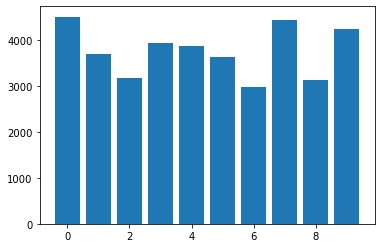

In [23]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH CLASS AFTER EXTRACTING BEATS FROM ECG:

my_dict3 = Counter(final_list_y)
keys3 = my_dict3.keys()
values3 = my_dict3.values()

plt.bar(keys3, values3)

In [24]:
X_train_array = np.array(final_list_X)

In [25]:
y_train_array = np.array(final_list_y)

In [30]:
print(X_train_array.shape)
print(y_train_array.shape)

(37685, 36)
(37685,)


In [31]:
# reshape the 2D training array into a 3D array before using neural networks.

X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))  

In [33]:
print(X_train_array.shape)
print(y_train_array.shape)

(37685, 36, 1)
(37685,)


In [34]:
X_train, X_test, y_train, y_test = records_tt_split(X_train_array, y_train_array)  # train-test split of the overall data.

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28264, 36, 1)
(9421, 36, 1)
(28264,)
(9421,)


In [37]:
# save these training and testing data as .npy files on the desktop.

path_to_store = r'C:\Users\harsh raj\OneDrive\Desktop\Research_Project'

np.save(path_to_store + '/' + 'XTrain.npy', X_train)

In [38]:
np.save(path_to_store + '/' + 'XTest.npy', X_test)
np.save(path_to_store + '/' + 'yTrain.npy', y_train)
np.save(path_to_store + '/' + 'yTest.npy', y_test)